In [1]:
import os
import pandas as pd
import glob

In [2]:
os.chdir('/home/xli/Data/Haihui/CD8-HP/HiC/HiC_Data_Summary/reps/dump_count_5k')
#os.listdir()

In [3]:
chr_set = list(range(1,20,1))+['X', 'Y']

In [4]:
n_chr=0
df_sum_all = pd.DataFrame()
for chrs in chr_set:
    #print (chrs)
    df_WT16  =pd.read_csv('WT_CD8_2019_chr'+str(chrs)+'.txt', header=None, sep="\t").rename(columns={2:'WT_19'})
    df_DKO16 =pd.read_csv('DKO_CD8_2019_chr'+str(chrs)+'.txt', header=None, sep="\t").rename(columns={2:'DKO_19'})
    df_tem = df_WT16.merge(df_DKO16, how='inner')#.fillna(0)
    df_tem.loc[:,"#chr"]=str(chrs)
    df_sum_all=df_sum_all.append(df_tem)
df_sum_all = df_sum_all.loc[:,['#chr',0,1,'WT_19', 'DKO_19']]
df_sum_all.to_csv('/home/xli/Data/Haihui/CD8-HP/Analysis_Notebook/2019_hic_interaction_count.bed', sep="\t", index=None)


In [10]:
df_WT16 = pd.read_csv('WT_CD8_2016_chr'+str(chrs)+'.txt', header=None, sep="\t", chunksize=100000)
df_WT16 


In [211]:
corr_set=()
df_corr_set=pd.DataFrame()

n_chr=0
df_sum_all = pd.DataFrame()
for chrs in chr_set:
    #print (chrs)
    df_WT16  =pd.read_csv('chr'+str(chrs)+'_WT_16.txt', header=None).rename(columns={0:'WT_16'})
    df_DKO16 =pd.read_csv('chr'+str(chrs)+'_DKO_16.txt', header=None).rename(columns={0:'DKO_16'})
    df_WT19  =pd.read_csv('chr'+str(chrs)+'_WT_19.txt', header=None).rename(columns={0:'WT_19'})
    df_DKO19 =pd.read_csv('chr'+str(chrs)+'_DKO_19.txt', header=None).rename(columns={0:'DKO_19'})
    df_sum = pd.concat([df_WT16,df_DKO16,df_WT19,df_DKO19],axis=1)
    df_sum = df_sum[df_sum.values.sum(axis=1) != 0] ## drop all zeros
    df_sum_all=df_sum_all.append(df_sum)
    df_corr_set.loc[n_chr,'chr']='chr'+str(chrs)
    for i in range(0,4):
        for j in range(i+1,4):
    #        print (df_sum.columns[i],df_sum.columns[j])
    #        print (df_sum.iloc[:,[i,j]].corr().iloc[0,1])
            COL_NAME=df_sum.columns[i]+'_'+df_sum.columns[j]
            CORR_VALUE=df_sum.iloc[:,[i,j]].corr().iloc[0,1]
            df_corr_set.loc[n_chr,COL_NAME]=CORR_VALUE
            
    n_chr+=1
df_corr_set = df_corr_set.set_index('chr')#.describe()
df_corr_set.columns.values

array(['WT_16_DKO_16', 'WT_16_WT_19', 'WT_16_DKO_19', 'DKO_16_WT_19',
       'DKO_16_DKO_19', 'WT_19_DKO_19'], dtype=object)

In [29]:
# chunksize test
df_chunk = pd.read_csv('WT_CD8_2016_chr'+str(chrs)+'.txt', header=None, sep="\t", chunksize=1000000)

#def filtered_long_range(df_interaction, max_distance):
    
for chunk in df_chunk:
    type(chunk)
    break
    
chunk_list = []  # append each chunk df here 
df_chunk = pd.read_csv('WT_CD8_2016_chr'+str(chrs)+'.txt', header=None, sep="\t", chunksize=100000)
for chunk in df_chunk:  
    # perform data filtering 
    chunk_filter = chunk_preprocessing(chunk)
    
    # Once the data filtering is done, append the chunk to list
    chunk_list.append(chunk_filter)
    
df_concat = pd.concat(chunk_list)

In [90]:
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white") 

# display plots in this notebook
%matplotlib inline

(array([1, 2, 3, 4, 5, 6]), <a list of 6 Text xticklabel objects>)

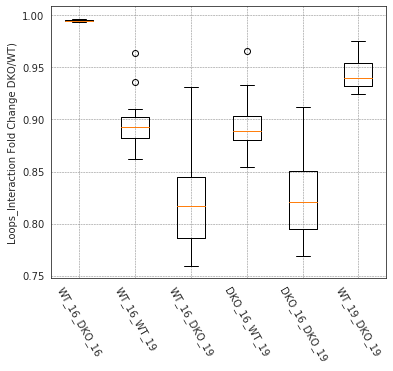

In [118]:
import re

all_data = [df_corr_set.iloc[:,0],df_corr_set.iloc[:,1],df_corr_set.iloc[:,2],df_corr_set.iloc[:,3],
            df_corr_set.iloc[:,4],df_corr_set.iloc[:,5]]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
axes.boxplot( all_data, showfliers=True)#,showmedians=True)
axes.grid(color='grey', linestyle='dashed', linewidth=0.5)

axes.set_ylabel('Loops_Interaction Fold Change DKO/WT)')
#axes.set_ylim(-5,100)
i=0
plt.setp( axes, xticks=[y + 1 for y in range(len(all_data))],
         xticklabels=df_corr_set.columns.values)
plt.xticks(rotation=-60)



In [213]:
df_sum_all.head(1)

,WT_16,DKO_16,WT_19,DKO_19
300,0.245872,0.261537,0.430637,0.388798


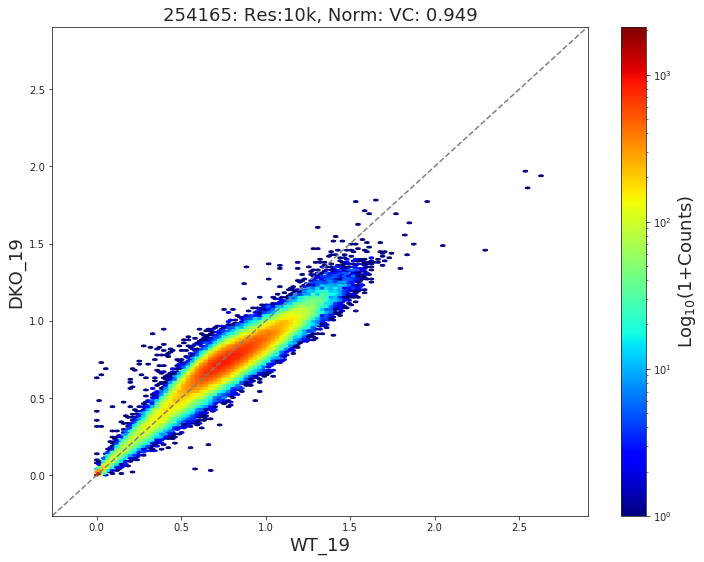

In [225]:
def hexbin_with_density(df, highlight_name, title_name, density_scale, drop_top_outlier):
    ### drop outlier
    df = df.drop(df.iloc[:,0].nlargest(n=drop_top_outlier,keep='first').index)
    
    
    range_limit=df.max().max()
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9), sharex=False, sharey=False)
    
    if density_scale == 'log':
        hb = ax.hexbin(df.iloc[:,[0]], df.iloc[:,[1]], gridsize=(100,100), cmap=plt.cm.jet,
                   bins='log',mincnt=1,alpha=2, edgecolors='face')
        cb = fig.colorbar(hb,ax=ax)
        cb.set_label('Log$_{10}$(1+Counts)', fontsize=18)
    else:
        hb = ax.hexbin(df.iloc[:,[0]], df.iloc[:,[1]], gridsize=(100,100), cmap=plt.cm.jet,
                   mincnt=1,alpha=2, edgecolors='face')
        cb = fig.colorbar(hb,ax=ax)
        cb.set_label('Counts', fontsize=18)

    ###  highlight a point
    if len(highlight_name) >= 1:
        for highlight_index in highlight_name[:]:
            ax.scatter(df[df.index == highlight_index].iloc[:,[0]],
                        df[df.index == highlight_index].iloc[:,[1]],
                        alpha=1.0,s=50,color='red', label=highlight_index,edgecolor='red')
            ax.text(df[df.index == highlight_index].iloc[:,0]-range_limit/20.0,
                      df[df.index == highlight_index].iloc[:,1]+range_limit/25.0, highlight_index, fontsize=16, color='r')


    ax.yaxis.grid(False)
    ax.set_ylim(-0.1*range_limit,range_limit+0.1*range_limit)
    ax.set_xlim(-0.1*range_limit,range_limit+0.1*range_limit)
    ax.set_xlabel(str(df.columns[0]), fontsize=18)
    ax.set_ylabel(str(df.columns[1]), fontsize=18)
    ax.plot([-0.1*range_limit,range_limit+0.1*range_limit], [-0.1*range_limit, range_limit+0.1*range_limit], ls="--", c="gray")
    ax.set_title(str(len(df))+ ': '+ title_name , fontsize=18)
    return 0

df_plot=np.log(1+df_sum_all.loc[:,['WT_19', 'DKO_19']])
aa = hexbin_with_density(df_plot, '', 'Res:10k, Norm: VC: ' + str("{:.3f}".format(df_plot.corr().iloc[0,1])), 'log',0)

Text(0.5, 0, '')

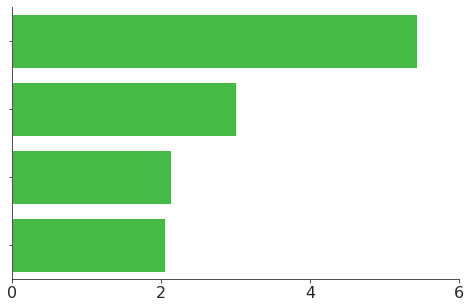

In [194]:
import seaborn as sns
import numpy as np

tips = sns.load_dataset("tips")
tips
pvalue=[3.64*10**-6,9.77*10**-4,7.26*10**-3,8.73*10**-3]
log_pvalue = -np.log10(pvalue)
df= pd.DataFrame(data=log_pvalue)

sns.set_style("ticks")

plt.figure(figsize=(8,5))

ax = sns.barplot(x=0, y=df.index, data=df,orient='h', color='limegreen')

plt.xticks(fontsize= 16)

ax.set_yticklabels([])
#ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0,6)

ax.set_xticks((0,2,4,6)) 
#ax.axes.get_xaxis().set_ticklabels([])
plt.xlabel('')